In [1]:
import subprocess
import sys

# Ensure scipy is up to date
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "scipy"])

# Ensure gensim and cython are properly installed
subprocess.check_call([sys.executable, "-m", "pip", "install", "cython"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "gensim"])

# Import necessary libraries
import os
import random
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import functools
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Updated import
from tensorflow.keras.preprocessing.text import Tokenizer  # Updated import
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Conv1D, MaxPooling1D
from keras.optimizers import Adam
from keras.initializers import Constant

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Download NLTK datasets
nltk.download("stopwords")  # for removing stop words
nltk.download("wordnet")  # for using wordnet lemmatizer
nltk.download('punkt')  # for using nltk.tokenize.word_tokenize
nltk.download('averaged_perceptron_tagger')  # for using nltk.pos_tag

# Install WordCloud package if not installed
try:
    from wordcloud import WordCloud
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wordcloud"])
    from wordcloud import WordCloud

# Now gensim can be imported without issues
import gensim

# Load your model if necessary
from keras.models import load_model


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nagma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nagma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nagma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nagma\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Sentiment Analysis using Custom Embedding and Word2Vec Embedding

In [3]:
path = "C:\\Users\\nagma\\Downloads\\Reviews.csv"

data = pd.read_csv(path, encoding="utf-8")
data = data.reindex(np.random.permutation(data.index))

print("Shape of data: ", data.shape)
data.head()

Shape of data:  (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
82573,82574,B000E1FYJW,A2Q3OLMYK98NK5,"John C. Lawrence ""Johnny""",3,3,5,1249171200,Jell-o suprise,I have been looking all over for this Jello. ...
331280,331281,B001P74NXM,A1LZJZIHUPLDV4,"vegancompassion ""anattanupassana""",10,17,5,1237075200,Vegan Organic Raw Choice,Vegan. Organic. Raw. Economical 'refill' or fa...
61767,61768,B003SLTETG,A2I41NCZG9OR58,Clay,41,41,1,1325030400,Having some issues with this door,I'm happy to hear that others are having good ...
324599,324600,B000GB0UGC,A311GV8XGDIEOY,"Erin Biegel ""Gabriels Mother""",6,29,1,1224288000,Ordered the item on the 7th.. wasnt shipped un...,Ordered the item on the 7th.. wasnt shipped un...
505901,505902,B001ELL512,A356ALXAC5COJ2,anknight,0,0,4,1346716800,Tasty coffee,I love Italian roast coffee. While this is no...


In [5]:
data.loc[[100, 200, 334, 424367, 1446], ["Score", "Summary", "Text"]]

,Score,Summary,Text
100,5,Taste wise it is a 6 star item,"The mouth says, ""How do I love thee, let me co..."
200,2,Altoids Smalls,"Even with small containers, they don't fill th..."
334,1,Does not taste very good,Taste like it is stale. Will not order this a...
424367,4,"Easy to prepare, excellent taste but...a bit t...","I really like Indian food for some reason, esp..."
1446,3,THICK SOUP,"Not bad, but like others say a bit too salty. ..."


In [7]:
reviews_text = data["Text"].values
reviews_title = data["Summary"].values
reviews_rating = data["Score"].values

In [9]:
# nltk libraries

stop_words = set(stopwords.words('english'))

lemmatiser = WordNetLemmatizer()

In [11]:
# returns the Part-Of-Speech(pos) tag which is required as an argument for
# lemmatizer for determiing the context of the word for lemmatization

def get_wordnet_pos(pos_tag):

    if pos_tag.startswith('J'):  
        return 'a' # adjective
    elif pos_tag.startswith('V'): 
        return 'v' # verb
    elif pos_tag.startswith('R'):
        return 'r' # adverb
    else:           
        return 'n' # fallback to noun

In [13]:
# example of lemmatization

example = "move moves moved moving study studies studying studied workers worker working worked go went gone"

tokens = word_tokenize(example) # Generate list of tokens
tokens_pos = pos_tag(tokens) 

print("Original   Lemmatized ")
for tok, tag in tokens_pos:
    pos = get_wordnet_pos(tag)
    print(tok, "       ",lemmatiser.lemmatize(tok, pos=pos))

Original   Lemmatized 
move         move
moves         move
moved         move
moving         move
study         study
studies         study
studying         study
studied         studied
workers         worker
worker         worker
working         work
worked         work
go         go
went         go
gone         go


In [8]:
# performs all sorts of preprocessing on text

def preprocess_text(text):
    
    # lowercase the entire text
    text = text.lower()
    
    # remove all html tags from dataset
    text = re.sub(r'<.*?>',"",text)
    
    # Replace special characters and punctuation by a 
    # blank ( except for full stop(.))
    text = re.sub('[^a-z0-9 \.]', '', text)
    
    # split the text into words
    words = word_tokenize(text) 
    
    # remove stop words like to, an, the, of, over, his, her, there, their ...
    words = [w for w in words if w =="not" or not w in stop_words ]
    
    # get pos tagging for words, required by lemmatizer
    words_pos = pos_tag(words) 
    
    lemmatized_words = []
    
    for word, tag in words_pos:
        pos = get_wordnet_pos(tag)
        lemmatized_word = lemmatiser.lemmatize(word, pos=pos)
        lemmatized_words.append(lemmatized_word)
    
    text = " ".join(lemmatized_words)
    
    
    return text

In [24]:
DATA_SIZE = reviews_text.size

reviews = []
labels = np.zeros(DATA_SIZE)

print(DATA_SIZE)

568454


In [25]:
# data preprocessing step
# will take several minutes!(almost an hour)

for i in range(DATA_SIZE):
    
    text = str(reviews_text[i])
    title = str(reviews_title[i])
    rating = reviews_rating[i]
    
    review = title + " " + text
    review = preprocess_text(review)
    reviews.append(review)

    if(rating > 3.0):
        labels[i] = 1 # Positive Review (1)

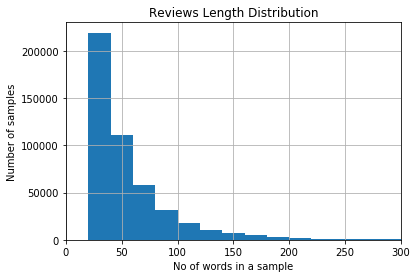

In [31]:
# plot showing lengthwise distribution of reviews

bins = [20*i for i in range(1, 30)]

plt.hist([len(s.split()) for s in reviews], bins=bins)

plt.xlabel('No of words in a review')
plt.ylabel('Number of reviews')
plt.title('Reviews Length Distribution')    

plt.axis([0, 300, 0, 230000])
plt.grid(True)

plt.show()

The majority of reviews are covered if length < 60 words

In [48]:
review_texts = []
review_labels = []

THRESHOLD_WORDS = 60

In [49]:
# considering only those reviews whose length <= (THRESHOLD_WORDS = 60)

for idx, review in enumerate(reviews):
    
    if(len(review.split()) <= THRESHOLD_WORDS):
        review_texts.append(review)
        review_labels.append(labels[idx])
        

In [50]:
review_labels = np.array(review_labels)

In [58]:
NEW_DATA_SIZE = review_labels.shape[0]

In [64]:
# TRAIN - VALIDATION - TEST SPLIT

TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TRAIN_INDEX = int(TRAIN_RATIO*NEW_DATA_SIZE)
VAL_INDEX = TRAIN_INDEX + int(VAL_RATIO*NEW_DATA_SIZE)

train_texts = review_texts[:TRAIN_INDEX]
y_train = review_labels[:TRAIN_INDEX]

val_texts = review_texts[TRAIN_INDEX:VAL_INDEX]
y_val = review_labels[TRAIN_INDEX:VAL_INDEX]

test_texts = review_texts[VAL_INDEX:]
y_test = review_labels[VAL_INDEX:]


In [65]:
# Random review

RAND_IDX = 78642
print(train_texts[RAND_IDX])
print("Label :", y_train[RAND_IDX])

good salty taste always favorite saltine . name implies good salty taste . amount salt seem gradually reduce level use many year ago . would prefer bit salt not find well alternative .
Label : 0.0


In [66]:
# calculates median words per sample

def get_num_words_per_sample(sample_texts):
    
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

In [68]:
# Facts about the dataset

print("Total training examples :", len(train_texts))
print("Total validation examples :", len(val_texts))
print("Total test dataset ", len(test_texts))
print("\nTotal classes :", 2)

print("\nMedian words per sample in training data : ", get_num_words_per_sample(train_texts))
print("Median words per sample in validation data : ", get_num_words_per_sample(val_texts[2:9]))
print("Median words per sample in test data : ", get_num_words_per_sample(test_texts)) 

Total training examples : 259666
Total validation examples : 86555
Total test dataset  86557

Total classes : 2

Median words per sample in training data :  29.0
Median words per sample in validation data :  32.0
Median words per sample in test data :  28.0


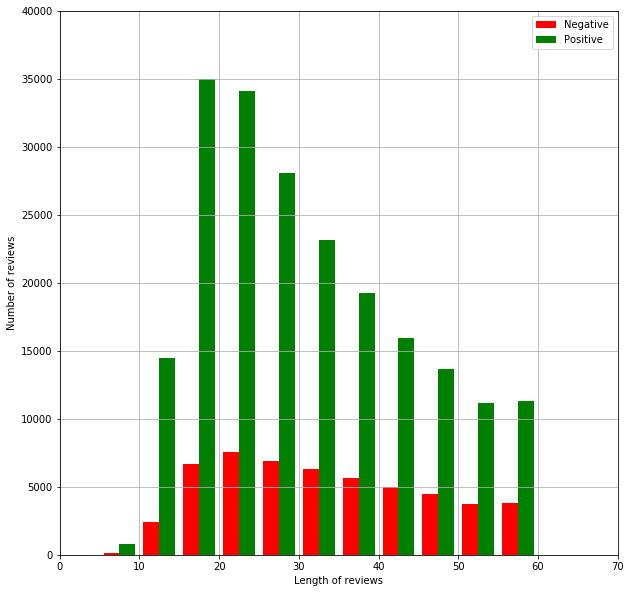

In [76]:
# plot showing lengthwise distribution of reviews labels

y = np.zeros((y_train.shape[0], 2))

for idx, review in enumerate(train_texts):
    l = len(review.split())
  
    if y_train[idx] == 1:
        y[idx][1] = l
    else: 
        y[idx][0] = l
        
mpl.rcParams['figure.figsize'] = (10,10)
        
plotlabels = [ 'Negative', 'Positive']
color = ['red', 'green']    

bins = [5*i for i in range(1,13)]

plt.hist(y,bins = bins,label = plotlabels,color = color)
plt.axis([0, 70, 0, 40000])

plt.title('Reviews Labels Distribution')   
plt.xlabel('Length of reviews')
plt.ylabel('Number of reviews') 

plt.legend()
plt.grid(True)
plt.show()

<BarContainer object of 50 artists>

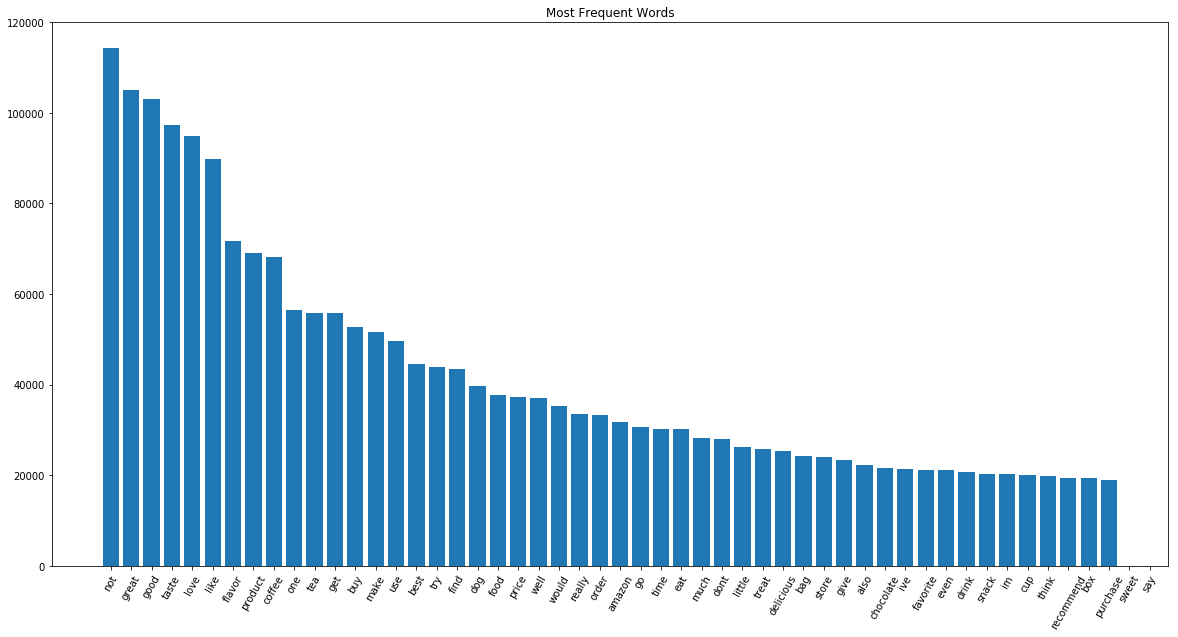

In [77]:
# tokenizing the reviews words

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

MOST_K_FREQUENT = 100
TOP_K_FREQUENT = 50

def get_key(word_freq_pair):
    word, freq = word_freq_pair
    return freq
  
# MOST_K_FREQUENT WORDS    
frequent_words = sorted(list(tokenizer.word_counts.items()), key = get_key, reverse = True)[:MOST_K_FREQUENT]

x = [i for i in range(MOST_K_FREQUENT)]
x_words = []
y_word_freq = []

for word, count in frequent_words:
    x_words.append(word)
    y_word_freq.append(count)

# plot showing most occuring words in the dataset    
    
mpl.rcParams['figure.figsize'] = (20,10)

plt.xticks(x, x_words)
plt.xticks(rotation=60)

plt.title("Most Frequent Words")

plt.bar(x[:TOP_K_FREQUENT], y_word_freq[:TOP_K_FREQUENT])

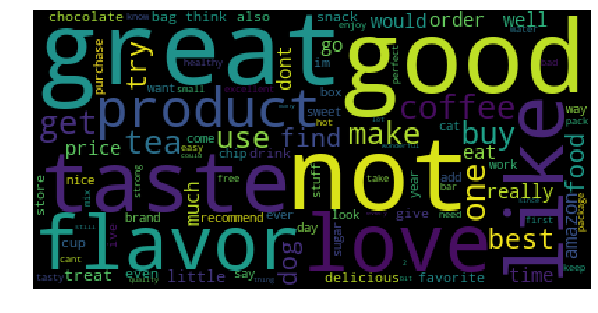

In [78]:
# word cloud showing most occuring words in the dataset

freq_dist = nltk.FreqDist(x_words)

wordcloud = WordCloud().generate_from_frequencies(freq_dist)

mpl.rcParams['figure.figsize'] = (10,10)

plt.imshow(wordcloud)

plt.axis("off")
plt.show()

In [79]:
# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = THRESHOLD_WORDS

# Create vocabulary with training texts.
tokenizer = Tokenizer(num_words=TOP_K)
tokenizer.fit_on_texts(train_texts)

# Vectorize training and validation texts.
x_train = tokenizer.texts_to_sequences(train_texts)
x_val = tokenizer.texts_to_sequences(val_texts)
x_test = tokenizer.texts_to_sequences(test_texts)

# Fix sequence length to MAX_SEQUENCE_LENGTH. Sequences shorter than the length are
# padded and sequences longer are truncated
x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
x_val = pad_sequences(x_val, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    

# Custom Embedding Model

In [158]:

# dimension of each word embedding
EMBEDDING_DIM = 100


model_custom_embedding = Sequential()

model_custom_embedding.add(Embedding(len(tokenizer.word_index)+1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_custom_embedding.add(Dropout(0.3))

model_custom_embedding.add(Conv1D(64, 5, activation='relu'))
model_custom_embedding.add(MaxPooling1D(pool_size=4))

model_custom_embedding.add(LSTM(100))
model_custom_embedding.add(Dropout(0.4))

model_custom_embedding.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)

model_custom_embedding.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_custom_embedding.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 60, 100)           9434700   
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 56, 64)            32064     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 14, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total para

In [159]:

# training the custom embedding model
model_custom_embedding_history = model_custom_embedding.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))


Train on 259666 samples, validate on 86555 samples
Epoch 1/10
259666/259666 [==============================] - 2405s 9ms/step - loss: 0.0582 - acc: 0.9798 - val_loss: 0.1730 - val_acc: 0.9479
Epoch 2/10
259666/259666 [==============================] - 2372s 9ms/step - loss: 0.0484 - acc: 0.9831 - val_loss: 0.2052 - val_acc: 0.9482
Epoch 3/10
259666/259666 [==============================] - 2368s 9ms/step - loss: 0.0432 - acc: 0.9852 - val_loss: 0.1909 - val_acc: 0.9497
Epoch 4/10
259666/259666 [==============================] - 2364s 9ms/step - loss: 0.0399 - acc: 0.9862 - val_loss: 0.2072 - val_acc: 0.9473
Epoch 5/10
259666/259666 [==============================] - 2370s 9ms/step - loss: 0.0356 - acc: 0.9876 - val_loss: 0.2341 - val_acc: 0.9485
Epoch 6/10
259666/259666 [==============================] - 2379s 9ms/step - loss: 0.0326 - acc: 0.9890 - val_loss: 0.2187 - val_acc: 0.9477
Epoch 7/10
259666/259666 [==============================] - 2368s 9ms/step - loss: 0.0304 - acc: 0.9893

### Training Accuracy - 99.14%
### Validation Accuracy - 94.86%

In [160]:
# model history parameters

history = model_custom_embedding_history.history

train_accuracy = history['acc']
train_loss = history['loss']

val_accuracy = history['val_acc']
val_loss = history['val_loss']

epochs = range(1, len(train_accuracy) + 1)

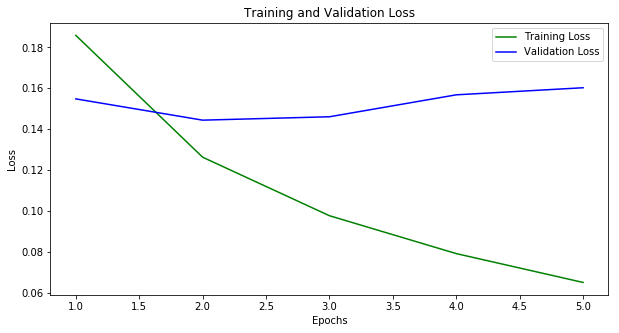

In [161]:
# plot showing training and validation losses

mpl.rcParams['figure.figsize'] = (10, 5)

plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

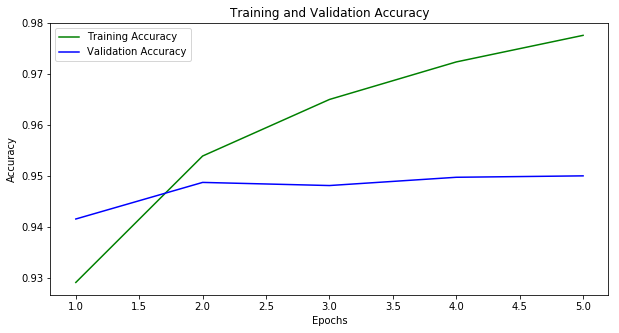

In [162]:
# plot showing training and validation accuracy

plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [163]:
# evaluating the model on test dataset

model_custom_embedding.evaluate(x_test, y_test)

86557/86557 [==============================] - 36s 410us/step


[0.23004449669752813, 0.949224210635766]

## Test Accuracy - 94.92%

In [166]:
# Custom test samples

samples = [
           "The taste of the biscuits was quite spectacular. It seemed as if it was taken straight from heaven",
           "Peanuts were too salty according to my taste",
           "Food was unhygienic. I fell ill after eating",
           "I am sure I liked what i had",
            "I am not sure I liked what i had",
            "If you are looking for a secret ingredient, go for it",
            "When i first bought this, i was confused about its quality and taste. But after eating this, my children fell in love with me. Thanks!!",
            "If you are looking for a quality food, dr. oetkers product always seem to be my first choice",
            "I'm not really a tea drinker but my husband is and he loves this tea. So on his behalf I'm recommending it. Just go on with my hubby's recommendation."
          ]

processed_samples = []
for sample in samples:
    processed_samples.append(preprocess_text(sample))

vectorized_samples = tokenizer.texts_to_sequences(processed_samples)
vectorized_samples = pad_sequences(vectorized_samples, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

predictions = model_custom_embedding.predict(vectorized_samples)

THRESHOLD_PREDICTION = 0.6

for idx, pred in enumerate(predictions):
    if(pred > THRESHOLD_PREDICTION):
        print("{}. Positive with {:.2f}% surity".format(idx+1, pred[0]*100))
    else:
        print("{}. Negative with {:.2f}% surity".format(idx+1, 100-pred[0]*100))


1. Positive with 99.64% surity
2. Negative with 99.84% surity
3. Negative with 96.88% surity
4. Positive with 66.48% surity
5. Negative with 99.47% surity
6. Positive with 88.35% surity
7. Positive with 99.54% surity
8. Positive with 94.34% surity
9. Positive with 96.55% surity


In [171]:
# saving the custom embedding model

model_custom_embedding.save("custom_embedding_model.h5")


## Word2Vec Model

In [180]:
# tokenizing the dataset for feeding to word2vec model

sentences =  [word_tokenize(review) for review in reviews]
    

In [181]:
# checking a random review
sentences[RAND_IDX]

['worst',
 'taste',
 'miso',
 'soup',
 'ever',
 'let',
 'start',
 'say',
 'love',
 'miso',
 'soup',
 'could',
 'sometimes',
 'eat',
 'every',
 'day',
 '.',
 'not',
 'miso',
 'soup',
 'snob',
 'either',
 'enjoy',
 'various',
 'brand',
 'recipe',
 '.',
 'however',
 'find',
 'particular',
 'brand',
 'dud',
 'lack',
 'flavor',
 'whatsoever',
 'pack',
 'way',
 'much',
 'onion',
 '.',
 'may',
 'fine',
 'quality',
 'ingredient',
 'reason',
 'buy',
 'first',
 'place',
 'not',
 'deliver',
 'taste',
 'department.disclaimer',
 'understand',
 'taste',
 'differ',
 '.']

In [183]:

# train word2vec model
model_word2vec = gensim.models.Word2Vec(sentences=sentences, size=EMBEDDING_DIM, window=5, workers=4, min_count=1)

# vocab size
words = list(model_word2vec.wv.vocab)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 339109


In [185]:
# word most similar to given word
model_word2vec.wv.most_similar('tasty')

[('delicious', 0.7955854535102844),
 ('yummy', 0.7198179960250854),
 ('flavorful', 0.7160199880599976),
 ('tastey', 0.643338680267334),
 ('good', 0.602535605430603),
 ('goodtasting', 0.5666812658309937),
 ('nice', 0.5660061240196228),
 ('satisfying', 0.5643998384475708),
 ('enjoyable', 0.549829363822937),
 ('sweet', 0.5464555025100708)]

In [189]:
# word most similar to given word
model_word2vec.wv.most_similar('horrible')

[('terrible', 0.9185449481010437),
 ('awful', 0.8790462017059326),
 ('horrid', 0.7899550199508667),
 ('nasty', 0.7880028486251831),
 ('disgust', 0.7879340052604675),
 ('bad', 0.7374359965324402),
 ('foul', 0.7031999230384827),
 ('gross', 0.7025725841522217),
 ('horrendous', 0.6756419539451599),
 ('yuck', 0.6686997413635254)]

In [216]:
# odd one out
print(model_word2vec.wv.doesnt_match("love hate tasty tea".split()))

tea


In [222]:
# word most similar to given word
model_word2vec.wv.similar_by_word("kitchen")[:3]

[('cabinet', 0.6798872947692871),
 ('pantry', 0.6145085096359253),
 ('cupboard', 0.612008810043335)]

In [231]:
# save the trained word2vec embeddings
filename = 'amazon_fine_food_reviews_embedding_word2vec.txt'
model_word2vec.wv.save_word2vec_format(filename, binary=False)

In [232]:
# creating dictionary of words containing corresponding word embeddings

embeddings_index = {}

f = open(filename,  encoding = "utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
    
f.close()

In [233]:
# creating embedding matrix for directly feeding to Embedding() layer of Keras

num_words = len(tokenizer.word_index)+1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    
    if i > num_words:
        continue
        
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        


In [236]:
# actual model

model_trained_word2vec = Sequential()

embedding_layer = Embedding(len(tokenizer.word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
model_trained_word2vec.add(embedding_layer)
model_trained_word2vec.add(Dropout(0.3))

model_trained_word2vec.add(Conv1D(64, 5, activation='relu'))
model_trained_word2vec.add(MaxPooling1D(pool_size=4))

model_trained_word2vec.add(LSTM(100))
model_trained_word2vec.add(Dropout(0.4))

model_trained_word2vec.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)

model_trained_word2vec.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_trained_word2vec.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 60, 100)           9434700   
_________________________________________________________________
dropout_15 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 56, 64)            32064     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 14, 64)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dropout_16 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total para

In [237]:

# training the model
model_trained_word2vec_history = model_trained_word2vec.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))


Train on 259666 samples, validate on 86555 samples
Epoch 1/10
259666/259666 [==============================] - 398s 2ms/step - loss: 0.2316 - acc: 0.9062 - val_loss: 0.1843 - val_acc: 0.9278
Epoch 2/10
259666/259666 [==============================] - 337s 1ms/step - loss: 0.1995 - acc: 0.9212 - val_loss: 0.1772 - val_acc: 0.9316
Epoch 3/10
259666/259666 [==============================] - 329s 1ms/step - loss: 0.1905 - acc: 0.9249 - val_loss: 0.1695 - val_acc: 0.9342
Epoch 4/10
259666/259666 [==============================] - 333s 1ms/step - loss: 0.1847 - acc: 0.9272 - val_loss: 0.1706 - val_acc: 0.9329
Epoch 5/10
259666/259666 [==============================] - 337s 1ms/step - loss: 0.1826 - acc: 0.9284 - val_loss: 0.1684 - val_acc: 0.9345
Epoch 6/10
259666/259666 [==============================] - 349s 1ms/step - loss: 0.1797 - acc: 0.9292 - val_loss: 0.1661 - val_acc: 0.9352
Epoch 7/10
259666/259666 [==============================] - 341s 1ms/step - loss: 0.1773 - acc: 0.9301 - val_

### Training Accuracy - 93.21%
### Validation Accuracy - 93.72%

In [238]:
# model history parameters

history = model_trained_word2vec_history.history

train_accuracy = history['acc']
train_loss = history['loss']

val_accuracy = history['val_acc']
val_loss = history['val_loss']

epochs = range(1, len(train_accuracy) + 1)

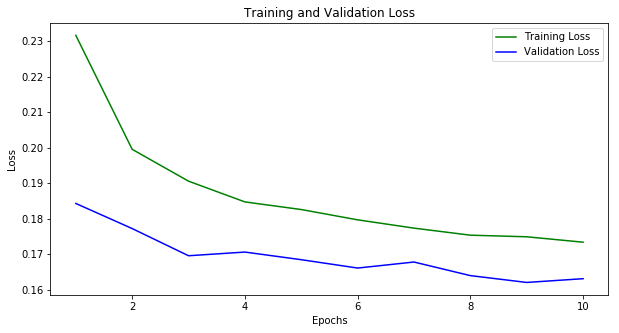

In [239]:
# plot showing training and validation losses

mpl.rcParams['figure.figsize'] = (10, 5)

plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

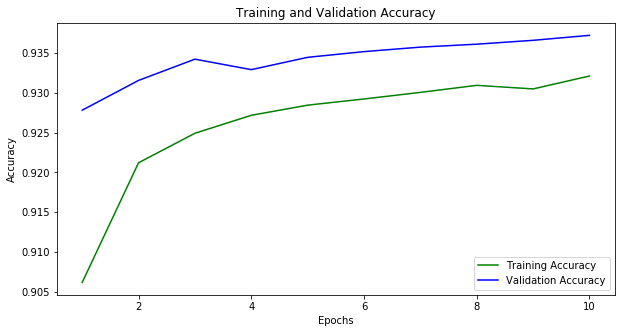

In [240]:
# plot showing training and validation accuracy

plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [241]:
# evaluating the model on test dataset
model_trained_word2vec.evaluate(x_test, y_test)

86557/86557 [==============================] - 40s 463us/step


[0.16001898619368626, 0.9389650750372587]

## Test Accuracy - 93.89%

In [242]:
# custom test samples

samples = [
           "The taste of the biscuits was quite spectacular. It seemed as if it was taken straight from heaven",
           "Peanuts were too salty according to my taste",
           "Food was unhygienic. I fell ill after eating",
           "I am sure I liked what i had",
            "I am not sure I liked what i had",
            "If you are looking for a secret ingredient, go for it",
            "When i first bought this, i was confused about its quality and taste. But after eating this, my children fell in love with me. Thanks!!",
            "If you are looking for a quality food, dr. oetkers product always seem to be my first choice",
            "I'm not really a tea drinker but my husband is and he loves this tea. So on his behalf I'm recommending it. Just go on with my hubby's recommendation."
          ]

processed_samples = []
for sample in samples:
    processed_samples.append(preprocess_text(sample))

vectorized_samples = tokenizer.texts_to_sequences(processed_samples)
vectorized_samples = pad_sequences(vectorized_samples, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

predictions = model_trained_word2vec.predict(vectorized_samples)

THRESHOLD_PREDICTION = 0.6

for idx, pred in enumerate(predictions):
    if(pred > THRESHOLD_PREDICTION):
        print("{}. Positive with {:.2f}% surity".format(idx+1, pred[0]*100))
    else:
        print("{}. Negative with {:.2f}% surity".format(idx+1, 100-pred[0]*100))


1. Positive with 90.88% surity
2. Negative with 83.67% surity
3. Positive with 79.18% surity
4. Positive with 75.59% surity
5. Negative with 64.46% surity
6. Positive with 90.54% surity
7. Positive with 99.54% surity
8. Positive with 90.42% surity
9. Positive with 89.64% surity


## The third prediction on "Food was unhygienic. I fell ill after eating" is wrong - Positive with 79.18% surity

## But the earlier model was rightly predicting "Food was unhygienic. I fell ill after eating" - Negative with 96.88% surity

In [243]:
# saving the trained word2vec model
model_trained_word2vec.save("trained_word2vec_model.h5")